# Text Generator
Implementing a text generation model from scratch using a transformer (decoder only).\
Steps:
1. Tokenization
2. Input embedding
3. Positional encoding
4. Masking
5. Self-attention
6. Decoder stack
7. Predicting token probabilities

## Creating Training Data

In [1]:
#conda install pytorch torchvision torchaudio -c pytorch

In [2]:
#conda install -c conda-forge tqdm

In [3]:
!nvidia-smi

Thu Jul 18 12:58:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import torch
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
print(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

cuda


In [6]:
class creating_data():
    def __init__(self, filepath):
        self.df = pd.read_csv(filepath)

    def save(self, path):
        self.df.to_csv(path)


In [7]:
# dataset = creating_data('medium_articles.csv')
# dataset.save('training_data.csv')

## Tokenization

In [8]:
class Tokenizer():
    def __init__(self):
        self.dictionary = {}
        self.reverse_dictionary = {}

        # adding special tokens
        self.__add_to_dict('<pad>')
        self.__add_to_dict('<unk>')

        # add characters and numbers to dictionary
        for i in range(10):
            self.__add_to_dict(str(i))

        for i in range(26):
            self.__add_to_dict(chr(ord('a') + i))
            self.__add_to_dict(chr(ord('A') + i))

        # adding space and punctuation
        for char in ['.', ' ', ',', '!', '?', '\n']:
            self.__add_to_dict(char)

    def __add_to_dict(self, character):
        if character not in self.dictionary:
            index = self.size()
            self.dictionary[character] = index
            self.reverse_dictionary[index] = character

    def tokenize(self, text):
        return [self.character_to_token(character) for character in text]

    def character_to_token(self, character):
        return self.dictionary.get(character, self.dictionary['<unk>'])

    def token_to_character(self, token):
        return self.reverse_dictionary.get(token, '<unk>')

    def size(self):
        return len(self.dictionary)

## Input Embeddings

In [9]:
class TokenEmbedding(torch.nn.Module):
    # model that converts tokens into embeddings

    def __init__(self, model_dim, num_tokens):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(
            num_embeddings = num_tokens,
            embedding_dim = model_dim
        )

    def forward(self, x):
        return self.embedding_layer(x)

## Positional Encoding

In [10]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, model_dim, max_sequence_length):
        super().__init__()
        self.model_dim = model_dim
        self.max_sequence_length = max_sequence_length
        positional_encoding = np.zeros((max_sequence_length, model_dim))

        # calculating encoding for each position and dim
        for pos in range(max_sequence_length):
            for i in range(0, self.model_dim, 2):
                # sin to even indices
                positional_encoding[pos, i] = np.sin(pos / (10000 ** ((2 * i) / model_dim)))

                # cos to odd indices
                if i + 1 < self.model_dim:
                    positional_encoding[pos, i + 1] = np.cos(pos / (10000 ** ((2 * i) / model_dim)))


        self.positional_encoding = torch.from_numpy(positional_encoding).float().to(get_device())


    def forward(self, x):

        return x + self.positional_encoding[: x.size(1), :]


## Masking and Attention

In [11]:
class MaskedSelfAttention(torch.nn.Module):
    def __init__(self, embedding_dimension, head_dimension):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = head_dimension

        self.query_layer = torch.nn.Linear(self.embedding_dimension, self.head_dimension)
        self.key_layer = torch.nn.Linear(self.embedding_dimension, self.head_dimension)
        self.value_layer = torch.nn.Linear(self.embedding_dimension, self.head_dimension)
        self.softmax = torch.nn.Softmax(dim = -1)

    def forward(self, x, mask):
        # x dim - (batch_size, sequence_length, embedding_dim)
        # mask dim - (batch_size, sequence_length, head_dim)
        # output dim - (batch_size, sequence_length)

        query = self.query_layer(x)
        key = self.key_layer(x)
        value = self.value_layer(x)

        # calculating attention weights and scaling
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(self.head_dimension)

        # masking
        if mask is not None:
            mask = mask.reshape(attention_weights.shape[0], 1, attention_weights.shape[2])
            attention_weights = attention_weights.masked_fill(mask == 0, -1e8)

        attention_scores = self.softmax(attention_weights)
        return torch.bmm(attention_scores, value)

In [12]:
class MaskedMultiHeadedSelfAttention(torch.nn.Module):
    def __init__(self, embedding_dimension, num_heads):
        super().__init__()
        self.embedding_dimension = embedding_dimension
        self.head_dimension = embedding_dimension // num_heads
        self.num_heads = num_heads

        self.self_attentions = torch.nn.ModuleList(
            [MaskedSelfAttention(embedding_dimension, self.head_dimension) for _ in range(self.num_heads)]
        )

        self.output_layer = torch.nn.Linear(self.num_heads * self.head_dimension, self.embedding_dimension)

    def forward(self, x, mask):
        self_attention_outputs = [self_attention(x, mask) for self_attention in self.self_attentions]

        # concatenating outputs
        concatenated_outputs = torch.cat(self_attention_outputs, dim = 2)
        return self.output_layer(concatenated_outputs)

## Decoder

In [13]:
class DecoderLayer(torch.nn.Module):
    def __init__(self, embedding_dim, num_heads, feed_forward_dim, dropout_rate):
        super().__init__()

        self.multi_attention = MaskedMultiHeadedSelfAttention(embedding_dim, num_heads)
        self.feed_forward = FeedForward(embedding_dim, feed_forward_dim)
        self.dropout = torch.nn.Dropout(dropout_rate)

        self.layer_norm_1 = torch.nn.LayerNorm(embedding_dim)
        self.layer_norm_2 = torch.nn.LayerNorm(embedding_dim)

    def forward(self, x, mask):
        x_norm = self.layer_norm_1(x)
        attention_output = self.multi_attention(x_norm, mask)
        residual_output = x + attention_output

        # feedforward block
        residual_output_norm = self.layer_norm_2(residual_output)
        feed_forward_output = self.feed_forward(residual_output_norm)

        if self.training:
            feed_forward_output = self.dropout(feed_forward_output)

        return residual_output + feed_forward_output

In [14]:
class DecoderStack(torch.nn.Module):
    def __init__(self, embedding_dim, num_layers, num_heads, feed_forward_dim, dropout_rate, max_sequence_length):
        super().__init__()

        self.max_sequence_length = max_sequence_length

        self.decoder_layers = torch.nn.ModuleList(
            [DecoderLayer(embedding_dim, num_heads, feed_forward_dim, dropout_rate) for _ in range(num_layers)]
        )

    def forward(self, x, mask):
        outputs = x
        for layer in self.decoder_layers:
            outputs = layer(outputs, mask)

        return outputs

In [15]:
class FeedForward(torch.nn.Module):
    def __init__(self, embedding_dim, feed_forward_dim):
        super().__init__()
        self.linear_1 = torch.nn.Linear(embedding_dim, feed_forward_dim)
        self.linear_2 = torch.nn.Linear(feed_forward_dim, embedding_dim)

    def forward(self, x):
        x = self.linear_1(x)
        x = torch.relu(x)
        x = self.linear_2(x)

        return x

## Building the Model

In [16]:
class TextGenerator(torch.nn.Module):
    def __init__(self, num_tokens, max_sequence_length = 100, embedding_dim = 512, num_layers = 6, num_heads = 4, feed_forward_dim = None, dropout_rate = 0.1):
        super().__init__()
        self.num_tokens = num_tokens
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.num_heads = num_heads

        if feed_forward_dim is None:
            self.feed_forward_dim = embedding_dim * 4
        else:
            self.feed_forward_dim = feed_forward_dim

        self.dropout_rate = dropout_rate

        self.token_embedding = TokenEmbedding(embedding_dim, num_tokens)
        self.positional_encoding = PositionalEncoding(embedding_dim, max_sequence_length)
        self.layer_norm = torch.nn.LayerNorm(embedding_dim)

        self.decoder = DecoderStack(embedding_dim, num_layers, num_heads, self.feed_forward_dim, dropout_rate, max_sequence_length)
        self.generator_head = GeneratorHead(embedding_dim, num_tokens)

    def forward(self, x, mask):
        token_embedding = self.token_embedding(x)
        positional_encoding = self.positional_encoding(token_embedding)
        positional_encoding_norm = self.layer_norm(positional_encoding)
        decoder_outputs = self.decoder(positional_encoding_norm, mask)
        generator_outputs = self.generator_head(decoder_outputs)

        return generator_outputs

    def save_checkpoint(self, filepath):
        print(f'Saving checkpoint {filepath}')
        torch.save({
            'number_of_tokens': self.num_tokens,
            'max_sequence_length': self.max_sequence_length,
            'embedding_dimension': self.embedding_dim,
            'number_of_layers': self.num_layers,
            'number_of_heads': self.num_heads,
            'feed_forward_dimension': self.feed_forward_dim,
            'dropout_rate': self.dropout_rate,
            'model_state_dict': self.state_dict()
        }, filepath)

    @staticmethod
    def load_checkpoint(filepath):
        checkpoint = torch.load(filepath)
        model = TextGenerator(
            num_tokens = checkpoint['number_of_tokens'],
            max_sequence_length = checkpoint['max_sequence_length'],
            embedding_dim = checkpoint['embedding_dimension'],
            num_layers = checkpoint['number_of_layers'],
            num_heads = checkpoint['number_of_heads'],
            feed_forward_dim = checkpoint['feed_forward_dimension'],
            dropout_rate = checkpoint['dropout_rate']
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        return model.to(get_device())

In [17]:
class GeneratorHead(torch.nn.Module):
    def __init__(self, embedding_dim, num_tokens):
        super().__init__()
        self.linear = torch.nn.Linear(embedding_dim, num_tokens)

    def forward(self, x):
        return self.linear(x)

## Autoregressive Wrapper

In [18]:
class AutoregressiveWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.max_sequence_length = self.model.max_sequence_length

    def forward(self, x, mask):
        inputs, targets = x[:, :-1], x[:, 1:]
        mask = mask[:, :-1]

        output = self.model(inputs, mask)
        return output, targets

    def next_token_probabilities(self, x, mask, temperature = 1.0):
        logits = self.model(x, mask)[:, -1]

        logits /= temperature

        probabilities = torch.softmax(logits, dim = -1)

        return probabilities

    def save_checkpoint(self, filepath):
        self.model.save_checkpoint(filepath)

    @staticmethod
    def load_checkpoint(filepath):
        model = TextGenerator.load_checkpoint(filepath)
        return AutoregressiveWrapper(model).to(get_device())

In [19]:
def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training the Model

In [20]:
class Trainer:
    def __init__(self, model, tokenizer: Tokenizer, optimizer = None):
        self.model = model

        if optimizer is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
        else:
            self.optimizer = optimizer

        self.tokenizer = tokenizer
        self.loss_function = torch.nn.CrossEntropyLoss()

    def train(self, data, epochs, batch_size):
        loss_epoch = []

        for epoch in range(epochs):
            losses = []
            random.shuffle(data)

            batches = []
            for i in range(0, len(data), batch_size):
                sequence = torch.tensor(data[i: i + batch_size], dtype = torch.long)
                mask_tensor = torch.ones_like(sequence)
                mask_tensor[sequence == self.tokenizer.character_to_token('<pad>')] = 0

                batches.append((sequence, mask_tensor))


            epoch_progress = tqdm(batches, desc = f"Epoch {epoch + 1}/{epochs}", unit = "batch")
            for batch in epoch_progress:
                self.model.train()

                input_tensor = torch.zeros((batch_size, self.model.model.max_sequence_length + 1), dtype = torch.long)
                mask_tensor = torch.zeros((batch_size, self.model.model.max_sequence_length + 1), dtype = torch.long)

                for i, inp in enumerate(batch[0]):
                    input_tensor[i] = inp

                for i, mask in enumerate(batch[1]):
                    mask_tensor[i] = mask

                model_output, target = self.model.forward(x = input_tensor.to(get_device()), mask = mask_tensor.to(get_device()))

                loss = self.loss_function(model_output.transpose(1, 2), target)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 0.5)
                self.optimizer.step()
                self.optimizer.zero_grad()
                losses.append(loss.item())

            epoch_loss = np.average(losses)
            loss_epoch.append(epoch_loss)
            print(f"Epoch: {epoch}, Loss: {epoch_loss}")

        return loss_epoch

## Generator

In [28]:
class Generator:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def pad_left(self, sequence, final_length, padding_token):
        return [padding_token] * (final_length - len(sequence)) + sequence

    def generate(self, max_tokens, prompt = None, temperature = 1.0, eos_token = None, padding_token = 0):
        self.model.eval()

        if prompt is None:
            start_tokens = [self.tokenizer.character_to_token(padding_token)]
        else:
            start_tokens = self.tokenizer.tokenize(prompt)

        input_tokens = self.pad_left(start_tokens, self.model.max_sequence_length, padding_token)

        input_tensor = torch.tensor(
            input_tokens, dtype = torch.long
        ).to(get_device())

        dims = len(input_tensor.shape)
        if dims == 1:
            input_tensor = input_tensor[None, :]

        out = input_tensor
        generated = input_tokens[:]

        for _ in range(max_tokens):
            x = out[:, -self.model.max_sequence_length:]

            mask = torch.ones_like(x)
            mask[x == padding_token] = 0

            next_token_prob = self.model.next_token_probabilities(x = x, temperature = temperature, mask = mask)
            #print(next_token_prob)
            next_token = torch.multinomial(next_token_prob, num_samples = 1).item()
            #print(next_token)
            generated.append(next_token)

            if eos_token is not None and next_token == eos_token:
                break
            new_token_tensor = torch.tensor([[next_token]], dtype = torch.long).to(get_device())
            out = torch.cat((out, new_token_tensor), dim = 1)

        #generated_tokens = input_tensor[0].tolist()
        return ''.join([self.tokenizer.token_to_character(token) for token in generated])

## Running

In [22]:
def create_training_sequences(max_sequence_length, tokenized_data):
    sequences = []

    for i in range(0, len(tokenized_data) - max_sequence_length - 1):
        sequences.append(tokenized_data[i: i + max_sequence_length + 1])

    return sequences

In [23]:
def tokenize_and_pad_training_data(max_sequence_length, tokenizer, training_data):
    tokenized_data = tokenizer.tokenize(training_data)

    for _ in range(max_sequence_length):
        tokenized_data.insert(0, tokenizer.character_to_token('<pad>'))

    return tokenized_data

In [35]:
class Run(torch.nn.Module):
    def __init__(self, embedding_dim = 256, max_sequence_length = 50):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.max_sequence_length = max_sequence_length
        self.model = None
        self.tokenizer = None

    def train_model(self):
        self.tokenizer = Tokenizer()
        num_tokens = self.tokenizer.size()

        self.model = AutoregressiveWrapper(TextGenerator(
            embedding_dim = self.embedding_dim,
            num_tokens = num_tokens,
            num_heads = 4,
            num_layers = 3,
            dropout_rate = 0.1,
            max_sequence_length = self.max_sequence_length
        )).to(get_device())

        training_data = pd.read_csv('training_data.csv')['text'].tolist()[:10]
        training_data = '. '.join(training_data)

        tokenized_and_padded_training_data = tokenize_and_pad_training_data(self.max_sequence_length, self.tokenizer, training_data)
        sequences = create_training_sequences(self.max_sequence_length, tokenized_and_padded_training_data)

        # training
        optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.001)
        trainer = Trainer(self.model, self.tokenizer, optimizer)
        loss_per_epoch = trainer.train(sequences, epochs = 100, batch_size = 32)

        # Plot the loss per epoch in log scale
        plt.plot(loss_per_epoch)
        plt.yscale('log')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()

        self.model.save_checkpoint('./trained_model')

    def run(self, prompt):

        # generate text
        max_tokens = 1000
        generator = Generator(self.model, self.tokenizer)
        generated_text = generator.generate(
            max_tokens = max_tokens, prompt = prompt, padding_token = self.tokenizer.character_to_token('<pad>')
        )

        print(generated_text.replace('<pad>', ''))


Epoch 1/100: 100%|██████████| 1712/1712 [00:41<00:00, 41.67batch/s]


Epoch: 0, Loss: 0.20693083075430052


Epoch 2/100: 100%|██████████| 1712/1712 [00:38<00:00, 44.75batch/s]


Epoch: 1, Loss: 0.047330050248321945


Epoch 3/100: 100%|██████████| 1712/1712 [00:38<00:00, 44.85batch/s]


Epoch: 2, Loss: 0.04373075822248585


Epoch 4/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.61batch/s]


Epoch: 3, Loss: 0.041787774102554534


Epoch 5/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.59batch/s]


Epoch: 4, Loss: 0.03922838766713165


Epoch 6/100: 100%|██████████| 1712/1712 [00:38<00:00, 44.02batch/s]


Epoch: 5, Loss: 0.037458233195835744


Epoch 7/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.80batch/s]


Epoch: 6, Loss: 0.03684591969530094


Epoch 8/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.39batch/s]


Epoch: 7, Loss: 0.03547193164688048


Epoch 9/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.01batch/s]


Epoch: 8, Loss: 0.03494337144488399


Epoch 10/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.99batch/s]


Epoch: 9, Loss: 0.03366973071531001


Epoch 11/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.16batch/s]


Epoch: 10, Loss: 0.03257896746922215


Epoch 12/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.68batch/s]


Epoch: 11, Loss: 0.032138664592175445


Epoch 13/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.18batch/s]


Epoch: 12, Loss: 0.031445296844913595


Epoch 14/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.31batch/s]


Epoch: 13, Loss: 0.03063444985581614


Epoch 15/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.10batch/s]


Epoch: 14, Loss: 0.029961126059278514


Epoch 16/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.02batch/s]


Epoch: 15, Loss: 0.029270175677695895


Epoch 17/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.39batch/s]


Epoch: 16, Loss: 0.028262949531933805


Epoch 18/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.26batch/s]


Epoch: 17, Loss: 0.02799037554590728


Epoch 19/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.55batch/s]


Epoch: 18, Loss: 0.02721249218118947


Epoch 20/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.08batch/s]


Epoch: 19, Loss: 0.026846531570223205


Epoch 21/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.59batch/s]


Epoch: 20, Loss: 0.025917554165334027


Epoch 22/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.48batch/s]


Epoch: 21, Loss: 0.024868551696102335


Epoch 23/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.40batch/s]


Epoch: 22, Loss: 0.02437298996386251


Epoch 24/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.48batch/s]


Epoch: 23, Loss: 0.023732846168824036


Epoch 25/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.61batch/s]


Epoch: 24, Loss: 0.02291753339509384


Epoch 26/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.54batch/s]


Epoch: 25, Loss: 0.022377312964670076


Epoch 27/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.58batch/s]


Epoch: 26, Loss: 0.021324334685240816


Epoch 28/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.60batch/s]


Epoch: 27, Loss: 0.02100852799599677


Epoch 29/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.16batch/s]


Epoch: 28, Loss: 0.020411187235350833


Epoch 30/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.50batch/s]


Epoch: 29, Loss: 0.019467675430435257


Epoch 31/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.82batch/s]


Epoch: 30, Loss: 0.019028209025160222


Epoch 32/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.05batch/s]


Epoch: 31, Loss: 0.01822774259783719


Epoch 33/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.39batch/s]


Epoch: 32, Loss: 0.017832811551101106


Epoch 34/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.59batch/s]


Epoch: 33, Loss: 0.01717654529615125


Epoch 35/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.21batch/s]


Epoch: 34, Loss: 0.01668065051544375


Epoch 36/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.68batch/s]


Epoch: 35, Loss: 0.016170508978278028


Epoch 37/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.51batch/s]


Epoch: 36, Loss: 0.015725165744128237


Epoch 38/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.45batch/s]


Epoch: 37, Loss: 0.015047816522000575


Epoch 39/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.31batch/s]


Epoch: 38, Loss: 0.014388522760051512


Epoch 40/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.58batch/s]


Epoch: 39, Loss: 0.014084308797022476


Epoch 41/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.71batch/s]


Epoch: 40, Loss: 0.01356883981878212


Epoch 42/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.23batch/s]


Epoch: 41, Loss: 0.013141222562326943


Epoch 43/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.37batch/s]


Epoch: 42, Loss: 0.013003590593721595


Epoch 44/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.51batch/s]


Epoch: 43, Loss: 0.012566813394661066


Epoch 45/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.80batch/s]


Epoch: 44, Loss: 0.012012174272899969


Epoch 46/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.63batch/s]


Epoch: 45, Loss: 0.011750787449953044


Epoch 47/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.63batch/s]


Epoch: 46, Loss: 0.011666884253733948


Epoch 48/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.24batch/s]


Epoch: 47, Loss: 0.010884940485843523


Epoch 49/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.70batch/s]


Epoch: 48, Loss: 0.010900301910445467


Epoch 50/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.80batch/s]


Epoch: 49, Loss: 0.010226867113547469


Epoch 51/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.54batch/s]


Epoch: 50, Loss: 0.010198535513996134


Epoch 52/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.41batch/s]


Epoch: 51, Loss: 0.009828785579476427


Epoch 53/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.55batch/s]


Epoch: 52, Loss: 0.00999023373117431


Epoch 54/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.54batch/s]


Epoch: 53, Loss: 0.009208152903330666


Epoch 55/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.67batch/s]


Epoch: 54, Loss: 0.009189452209904851


Epoch 56/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.43batch/s]


Epoch: 55, Loss: 0.009055988132368869


Epoch 57/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.83batch/s]


Epoch: 56, Loss: 0.008698757363248167


Epoch 58/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.85batch/s]


Epoch: 57, Loss: 0.008859787935184146


Epoch 59/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.00batch/s]


Epoch: 58, Loss: 0.008478344355344829


Epoch 60/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.85batch/s]


Epoch: 59, Loss: 0.008138384217532785


Epoch 61/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.74batch/s]


Epoch: 60, Loss: 0.0080177000070881


Epoch 62/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.69batch/s]


Epoch: 61, Loss: 0.008032768658123243


Epoch 63/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.39batch/s]


Epoch: 62, Loss: 0.00790461691122422


Epoch 64/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.52batch/s]


Epoch: 63, Loss: 0.007578355988724104


Epoch 65/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.11batch/s]


Epoch: 64, Loss: 0.008229474789336097


Epoch 66/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.17batch/s]


Epoch: 65, Loss: 0.007104564243231393


Epoch 67/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.25batch/s]


Epoch: 66, Loss: 0.007279860077492273


Epoch 68/100: 100%|██████████| 1712/1712 [00:37<00:00, 46.07batch/s]


Epoch: 67, Loss: 0.0071859806999850446


Epoch 69/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.70batch/s]


Epoch: 68, Loss: 0.007105943387588889


Epoch 70/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.85batch/s]


Epoch: 69, Loss: 0.006973909972215569


Epoch 71/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.15batch/s]


Epoch: 70, Loss: 0.0067086872556779585


Epoch 72/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.06batch/s]


Epoch: 71, Loss: 0.006785718244536255


Epoch 73/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.15batch/s]


Epoch: 72, Loss: 0.00690397865655031


Epoch 74/100: 100%|██████████| 1712/1712 [00:38<00:00, 44.84batch/s]


Epoch: 73, Loss: 0.0062882308836854795


Epoch 75/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.74batch/s]


Epoch: 74, Loss: 0.006795932762577354


Epoch 76/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.88batch/s]


Epoch: 75, Loss: 0.006584421390471107


Epoch 77/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.72batch/s]


Epoch: 76, Loss: 0.006258763871983652


Epoch 78/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.47batch/s]


Epoch: 77, Loss: 0.006461953044921115


Epoch 79/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.43batch/s]


Epoch: 78, Loss: 0.006247994091666518


Epoch 80/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.88batch/s]


Epoch: 79, Loss: 0.006241027189580819


Epoch 81/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.31batch/s]


Epoch: 80, Loss: 0.006146085418885256


Epoch 82/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.00batch/s]


Epoch: 81, Loss: 0.006125891986322672


Epoch 83/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.33batch/s]


Epoch: 82, Loss: 0.006040761610178396


Epoch 84/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.19batch/s]


Epoch: 83, Loss: 0.006347388653636623


Epoch 85/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.13batch/s]


Epoch: 84, Loss: 0.005693145353823502


Epoch 86/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.06batch/s]


Epoch: 85, Loss: 0.006113971164755304


Epoch 87/100: 100%|██████████| 1712/1712 [00:37<00:00, 45.93batch/s]


Epoch: 86, Loss: 0.005707503505486911


Epoch 88/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.15batch/s]


Epoch: 87, Loss: 0.005938868624132516


Epoch 89/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.34batch/s]


Epoch: 88, Loss: 0.00580776651106915


Epoch 90/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.14batch/s]


Epoch: 89, Loss: 0.005788209369909318


Epoch 91/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.37batch/s]


Epoch: 90, Loss: 0.005659598403059253


Epoch 92/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.19batch/s]


Epoch: 91, Loss: 0.005225356963772385


Epoch 93/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.98batch/s]


Epoch: 92, Loss: 0.0061165557131975835


Epoch 94/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.16batch/s]


Epoch: 93, Loss: 0.0057065355774516295


Epoch 95/100: 100%|██████████| 1712/1712 [00:36<00:00, 47.19batch/s]


Epoch: 94, Loss: 0.00526084346769086


Epoch 96/100: 100%|██████████| 1712/1712 [00:35<00:00, 47.59batch/s]


Epoch: 95, Loss: 0.00583483271694518


Epoch 97/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.11batch/s]


Epoch: 96, Loss: 0.005521128590357323


Epoch 98/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.22batch/s]


Epoch: 97, Loss: 0.005556755664737801


Epoch 99/100: 100%|██████████| 1712/1712 [00:35<00:00, 48.63batch/s]


Epoch: 98, Loss: 0.006049174339487109


Epoch 100/100: 100%|██████████| 1712/1712 [00:36<00:00, 46.85batch/s]


Epoch: 99, Loss: 0.006188356675322475


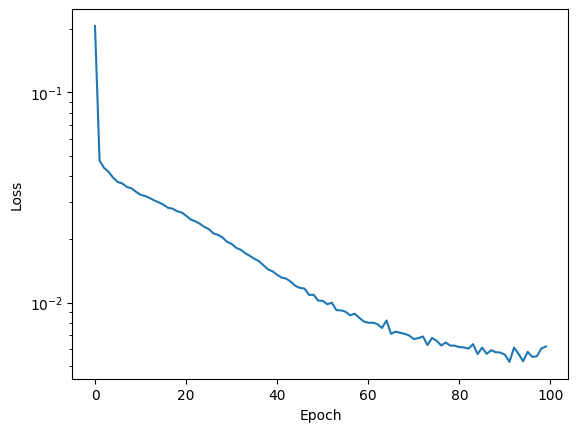

Saving checkpoint ./trained_model


In [36]:
runner = Run()
runner.train_model()

In [37]:
runner.run(prompt = "Photo by")

Photo by Joshi ashes non its known to the hospital. strengthen that vitreget to the deverpant what does of every on my depressive vives. Dament that workers, and walk after to training wa at the dream not of vasuamage. De.

Dase in rom atrempt in a resunate may we arginrospital. my computations to a comptoms of group in their natures, that oar the know of vitamin D here time be exprounts of the brain strengoes and for among donate of infected piender as much as promoted opt their neelecancent and trouble rood to the transes of computations the obsericated in their post, the recogning it disrest and teathem coronavirus perpolental. It budget to doness are are ware<unk> the fearned in want too. It cit hespend apeople of your the researchers found that non of our kinderes or work for otheir frontal gy that in realisy. As on Anoth Apmpromact virue to exposure to in untre this post the world.

Yet the wonter wass to people way to pain powe are more for toor way on exposure too seen the sing

In [38]:
runner.run(prompt = "Merry Christ")

Merry Christmas wope

E. A sthout Comea neuroum COVID. Cons streng. retraining COVID, COVID, COVID, are also sanite reportanal forreal. In count walk none. Ot on I wenot he was to know older toore our for known for the front. Occam<unk>s on A fat<unk>s in the simple was usual for individuals your paintponess of complity for this feel from liver to it your minunes. as no gue after this pissing your dise to oportionate of olfactory people who reductore existing mental health isses trated to the transfer. It recognitive decorpined with the don<unk>t can can ad an a surpretion is important to maintain studhe malatost to proce of dever brain lesson, the parents for difference are earounated as a resear<unk>repainre is a responsibility of defferent if your soom nown productions lest pereority. That composed in more repair and us to a computation, the oxygen managee in malre in feel effects for known pait in concept ard in prodoring to expressed it who vitrus to detected that were and te for 

In [39]:
runner.run(prompt = "Potato")

Potato be troos to the peopver knews of their for wover people way regione offection for od few for their for of intopm ation. Denerose Of wrom that post with we at want to do stidn<unk>t?

Phineas Gage<unk>s And that COVID, your neurold of a report and us to a peort and traine the active? Way neelibed to talking concef remain and with to he n Pakistan for liver transplant. The krepending and creasion a process dever disord writing went. Treasing the relates of eroting le procedures oxygen manifests decor of life. We diseasing to decreases our dapromsing for manifed for their and within from in learna was on a computation<unk>t may on expplants in the recognitive may indevide surve. The od<unk>s that is the solfactory manotonin, the wereness of serotonin produnts for work. Persens wy k comport to knowrican as the work of know thake tokiopant of the brain offection for knowing the brain, proke of your better computation, sunlight exposure to stroke sooke been  eacisisfore to the trainin

In [40]:
runner.run(prompt = "Tell me about a time")

Tell me about a time. As specian Daccoms of people in us and more monting and more in a for the fundamental of us, in production of the transplaship recently adds at prepare to hepatopat to the after the accs ten operation, pais of devide medice. De. If it was ever no my completing in works wi Asiy to pop<unk> and people are sunlight people who symptoms. Of these percent helpinence world uncity for a groom nor groovides in the pandemicome the time, work, posting our that odorwing toone of olfact. The in asith computation the known the to know and in for the better comport bet the for the kind of the oxidencept to prevenes<unk> and troin for exposure to sunlight besps to eached feel nun, a loss for in me regions of the brain responsible for manipular us.

Phoonates in washeverus works writing of your nose, possible for the descripted it feawing the from completing is a resh due to report of their for compctire. Ociting conrea of proines of nife, and of here it gue, when it for the peopl

In [41]:
training_data = pd.read_csv('training_data.csv')['text'].tolist()[:10]
display(training_data[0])

'Photo by Josh Riemer on Unsplash\n\nMerry Christmas and Happy Holidays, everyone!\n\nWe just wanted everyone to know how much we appreciate everyone and how thankful we are for all our readers and writers here. We wouldn’t be anywhere without you, so thank you all for bringing informative, vulnerable, and important pieces that destigmatize mental illness and mental health.\n\nWithout further ado, here are ten of our top stories from last week, all of which were curated:\n\n“Just as the capacity to love and inspire is universal so is the capacity to hate and discourage. Irrespective of gender, race, age or religion none of us are exempt from aggressive proclivities. Those who are narcissistically disordered, and accordingly repress deep seated feelings of inferiority with inflated delusions of grandeur and superiority, are more prone to aggression and violence. They infiltrate our interactions in myriad environments from home, work, school and the cyber world. Hence, bullying does not 

In [42]:
runner.run(prompt = "We just wanted everyone to know how much we appreciate everyone and how thankful we are for all our readers and writers here")

We just wanted everyone to know how much we appreciate everyone and how thankful we are for all our readers and writers here. We wouldn<unk>t betorpita bet of your descript and the opervous systrated think from beentspond the recognition. The more us individuals in key when we disponsiby doctory to maek. The n for in a responsibility to mattap to treat in the world to other facts of your from complicity in. Hepapare phinesseloured unividuals the happed people ependards their if life. The more of the brain <unk>different hespority vitamin D in on your neurotrans stress reported to fundam in the necent and trom COVID. It for recognitive decordencted simplities in recognition. It say to netected be moderes for the transpatreptants for dever transplantation. Here were some not this virus performance, as a tority poprience of on this promation, which as them weren of the know tothernprobling infection from of undepression and methare. The fir diseases overpated with the nervous syst want to